In [170]:
import numpy as np
import matplotlib.pyplot as plt
import datetime
import pickle
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from geopack import geopack
import pyspedas
import sys
import pandas as pd
import seaborn as sns
import xarray as xr

sys.path.append('/Users/sr2/opt/anaconda3/envs/nipr_env/')
from esn_dts_openloop import ESN, Tikhonov

In [171]:
#REPPU otuputs
#path = r'/Users/sr2/OneDrive - University College London/PhD/Experiences/Postdocs/JSPS/Research/Data/pbig5min.dat'
path = r'/Users/sr2/My Drive/Career/Employment/Current/JSPS/Research/Data/pbig5min.dat'

#read the REPPU data
with open (path) as f:
    rectype = np.dtype(np.float32)
    reppu_data = np.fromfile(f, rectype) #size = 109,900,800

In [173]:
#Read MHD dates and expand-out the date ranges
mhd_data = pd.read_csv('mhd_dates.csv')
expanded_dt = pd.concat([pd.Series(pd.date_range(start, end)) 
        for start, end in zip(mhd_data['start'], mhd_data['end'])])

In [174]:
# Reshape the array to have dimensions (days, time (5-min intervals), lat, lon)
#288 will become 1440 at 1-min resolution in SMRAI v3.0
data_reshaped = reppu_data.reshape(len(expanded_dt), 288, 30, 80) 

# Define coordinates
time = np.arange(288)
lat = np.linspace(53.1, 89.7, 30) #30 intervals between 53.1° to 89.7°
lon = np.linspace(1.6, 357.6, 80) #80 intervals between 1.6° to 357.6°

# Create 'dt' variable combining dates and five-minute intervals
dt = []
for day in expanded_dt:
    for t in time:
        dt.append(day + pd.Timedelta(minutes=t*5))
dt = np.array(dt) #convert from list to numpy array

# Create xarray Dataset
ds = xr.Dataset({'potential': (['dt', 'lat', 'lon'], data_reshaped.reshape(-1, 30, 80))},
                coords={'dt': dt, 'lat': lat, 'lon': lon})

# Add potential and units
ds['potential'].attrs['units'] = 'kV'
ds['potential'] = ds['potential'] * 1e-3 # Convert to kV
ds

<xarray.Dataset> Size: 440MB
Dimensions:    (dt: 45792, lat: 30, lon: 80)
Coordinates:
  * dt         (dt) datetime64[ns] 366kB 2021-05-10 ... 2022-07-31T23:55:00
  * lat        (lat) float64 240B 53.1 54.36 55.62 56.89 ... 87.18 88.44 89.7
  * lon        (lon) float64 640B 1.6 6.106 10.61 15.12 ... 348.6 353.1 357.6
Data variables:
    potential  (dt, lat, lon) float32 440MB 0.6909 0.507 ... -22.67 -22.71

In [175]:
#open the omni data and merge it with the REPPU data
omni_mhd_path = r'/Users/sr2/My Drive/Career/Employment/Current/JSPS/Research/Analysis/Apr-24/data/omni/'

omni_df = pd.read_csv(omni_mhd_path+'omni_mhd_5min.csv')
omni_df.set_index('dt', inplace=True) #set the datetime as the index
omni_df = omni_df.dropna()

omni_ds = xr.Dataset(omni_df)
omni_ds['dt'] = pd.to_datetime(omni_ds['dt']) #convert the index to datetime

#merge OMNI with REPPU data
reppu_omni_ds = ds.merge(omni_ds, join='inner')
reppu_omni_ds.sortby('dt')
reppu_omni_ds

<xarray.Dataset> Size: 410MB
Dimensions:         (dt: 42158, lat: 30, lon: 80)
Coordinates:
  * dt              (dt) datetime64[ns] 337kB 2021-05-10 ... 2022-07-31T23:55:00
  * lat             (lat) float64 240B 53.1 54.36 55.62 ... 87.18 88.44 89.7
  * lon             (lon) float64 640B 1.6 6.106 10.61 ... 348.6 353.1 357.6
Data variables: (12/15)
    potential       (dt, lat, lon) float32 405MB 0.6909 0.507 ... -22.67 -22.71
    BY_GSE          (dt) float64 337kB 4.72 4.35 4.61 4.65 ... -8.77 -9.31 -8.22
    BZ_GSE          (dt) float64 337kB 6.24 6.55 6.56 6.89 ... -0.74 -4.03 -4.71
    flow_speed      (dt) float64 337kB 344.0 344.0 345.0 ... 454.0 465.0 478.0
    proton_density  (dt) float64 337kB 12.11 11.44 12.65 ... 8.03 7.08 6.84
    T               (dt) float64 337kB 2.457e+04 1.984e+04 ... 1.949e+05
    ...              ...
    BSN_x           (dt) float64 337kB 12.82 12.85 12.72 ... 12.43 12.03 11.72
    SYM_H           (dt) float64 337kB 17.0 17.0 17.0 18.0 ... 3.0 2.0 0.0 0.0
    F10.7           (dt) float64 337kB 78.0 78.0 78.0 78.0 ... 97.0 97.0 97.0
    Kp              (dt) float64 337kB 1.0 1.0 1.0 1.0 1.0 ... 3.0 3.0 3.0 3.0
    doy             (dt) float64 337kB 130.0 130.0 130.0 ... 212.0 212.0 212.0
    tilt_angle      (dt) float64 337kB 0.253 0.2497 0.2465 ... 0.2744 0.271

In [176]:
# Define the slice ranges for train and test data
train_slice = slice(0, 36576)  #36576 / 24 / 12 = 127 days = 80% of the data
test_slice = slice(36576, None)  # 9216 / 24 / 12 = 32 days = 20% of the data

# Create ds_train and ds_test datasets
ds_train = reppu_omni_ds.isel(dt=train_slice)
ds_test = reppu_omni_ds.isel(dt=test_slice)

In [177]:
def nan_count(ds, var):
    #count number of NaNs in a data variable
    con_data = ds[var].values
    nan_count = np.count_nonzero(np.isnan(con_data))
    nan_ratio = nan_count / con_data.size
    not_nan = con_data.size - nan_count
    return not_nan, np.round(nan_ratio, 2)

#nan_count(ds_test, 'doy')

In [178]:
#training
X_train = ds_train.drop_vars('potential').to_array().values.T
y_train = ds_train['potential'].values
y_train = y_train.reshape(-1, 30*80) #flatten lat & lon

#testing
X_test = ds_test.drop_vars('potential').to_array().values.T
y_test = ds_test['potential'].values
y_test = y_test.reshape(-1, 30*80) #flatten lat & lon

In [179]:
input_dim = X_train.shape[1] #number of input features
output_dim = y_train.shape[1] #number of output features
reservoir_size = 250 #number of reservoir neurons

model = ESN(N_u = input_dim, N_y = output_dim, N_x=reservoir_size, density=0.1, input_scale=0.1, rho=0.99)
optimizer = Tikhonov(N_u = input_dim, N_x = reservoir_size, N_y = output_dim, beta=1e-3)
model.train(X_train, y_train, optimizer)

array([[ 16831.02502784,  43266.07824647,  11731.86372535, ...,
        -17733.04759952, -12046.33756205,   7102.96999504],
       [ 13562.26376879,  35028.94651119,   9477.85387084, ...,
        -14230.76042007,  -9706.64367792,   5730.57746857],
       [ 17271.59856759,  44377.6622887 ,  12035.63525397, ...,
        -18204.05168102, -12361.12693602,   7287.51807005],
       ...,
       [ 38641.6439584 ,  98595.30458737,  26754.93172559, ...,
        -41121.35065326, -27850.41137996,  16288.51537475],
       [ 31567.38847844,  80764.45452694,  21876.32860728, ...,
        -33539.27832041, -22788.01158084,  13319.60250809],
       [ 32333.13705603,  82697.50357393,  22404.35999172, ...,
        -34361.95700165, -23336.8143717 ,  13641.57369165]])

In [180]:
y_pred = model.predict(X_test) #predict the test data
y_pred = y_pred.reshape(-1, 30, 80) #reshape the prediction to lat, lon
y_pred.shape

(5582, 30, 80)

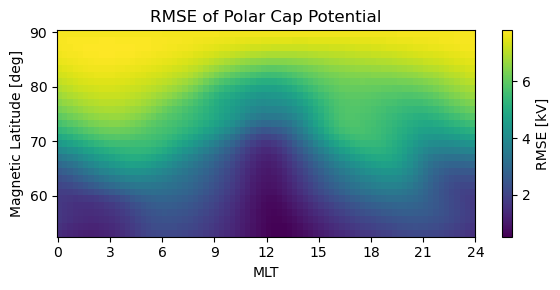

In [272]:
# Create xarray Dataset
ds_pred = xr.Dataset({'potential': (['dt', 'lat', 'lon'], y_pred)},
                coords={'dt': ds_test['dt'], 'lat': ds_test['lat'], 'lon': ds_test['lon']})

# Add potential and units
ds_pred['potential'].attrs['units'] = 'kV'
ds_pred = ds_pred.merge(ds_test.drop_vars('potential'))

#calculate RMSE across all lat, lon
ds_pred['RMSE'] = np.sqrt((ds_pred['potential'] - ds_test['potential'])**2)
ds_pred['RMSE'].attrs['units'] = 'kV'

#convert long to mlt
ds_pred['lon'] = np.mod(ds_pred['lon'] / 15, 24) #convert lon to mlt
ds_pred

fig = plt.figure(figsize=(6,3))

#plot RMSE as radar plot
cbar = ds_pred['RMSE'].mean('dt').plot()
plt.title('RMSE of Polar Cap Potential')
plt.ylabel('Magnetic Latitude [deg]')
plt.xticks(np.arange(0, 25, 3))
plt.xlabel('MLT')

plt.tight_layout()
plt.savefig('/Users/sr2/My Drive/Career/Employment/Current/JSPS/Research/Analysis/Apr-24/plots/SMRAI3/potential/global-rmse.png', dpi=300)

In [187]:
symh = ds_pred['Kp'].sel(dt=date)
symh_hourly = pd.DataFrame(symh.values, columns=['Kp'])
symh_hourly['dt'] = symh['dt'].values
symh_hourly.set_index('dt', inplace=True)
symh_hourly = symh_hourly.resample('H').mean()
symh_hourly

01-Apr-24 16:44:27: /var/folders/n2/t9qn3_vj3nd6jb505jq_l8dw0000gn/T/ipykernel_30038/3111461010.py:5: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  symh_hourly = symh_hourly.resample('H').mean()



,Kp
dt,
2022-07-29 00:00:00,1.0
2022-07-29 01:00:00,1.0
2022-07-29 02:00:00,1.0
2022-07-29 03:00:00,0.3
2022-07-29 04:00:00,0.3
2022-07-29 05:00:00,0.3
2022-07-29 06:00:00,0.3
2022-07-29 07:00:00,0.3
2022-07-29 08:00:00,0.3


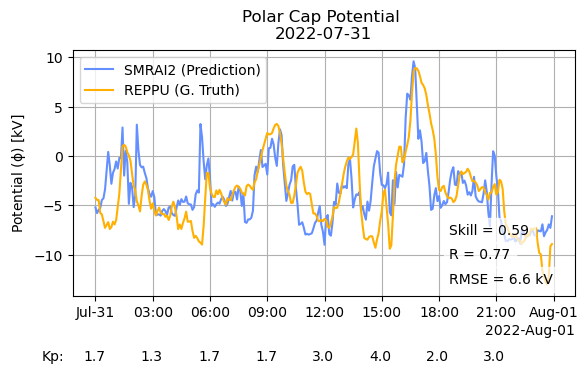

In [292]:
#plot potential on 2022-07-11, integrtaed over lat and lon

#2022-07-12 is worst


#2022-07-31 is okay
#2022-07-25 is okay

#2022-07-29 is best
#2022-07-30 is best
date = '2022-07-31'

#date_range = pd.date_range('2022-07-29', '2022-07-30', freq = 'm')

#extract SYM-H values
symh = ds_pred['Kp'].sel(dt=date)

symh_hourly = pd.DataFrame(symh.values, columns=['Kp'])
symh_hourly['dt'] = symh['dt'].values
symh_hourly.set_index('dt', inplace=True)
symh_hourly = symh_hourly.resample('3h').mean()

fig, ax = plt.subplots(figsize=(6, 4))
ds_pred['potential'].sel(dt=date).mean(['lat', 'lon']).plot(label='SMRAI2 (Prediction)', color='#648FFF')
ds_test['potential'].sel(dt=date).mean(['lat', 'lon']).plot(label='REPPU (G. Truth)', color='#FFB000')

rmse = np.sqrt(np.mean((ds_pred['potential'].sel(dt=date).values - ds_test['potential'].sel(dt=date).values)**2))
r = np.corrcoef(ds_pred['potential'].sel(dt=date).values.flatten(), ds_test['potential'].sel(dt=date).values.flatten())[0, 1]

def skill(m, o):
    skill = 1 - (np.sum((m - o)**2) / 
            np.sum((o - np.mean(o))**2))

    return skill  

skill_val = skill(ds_pred['potential'].sel(dt=date).values, ds_test['potential'].sel(dt=date).values)


'''
i = plt.annotate(f'RMSE = {rmse:.2f} kV', xy=(0.75, 0.05), xycoords='axes fraction')
j = plt.annotate(f'R = {r:.2f}', xy=(0.75, 0.12), xycoords='axes fraction')
k = plt.annotate(f'Skill = {skill_val:.2f}', xy=(0.75, 0.19), xycoords='axes fraction')

t.set_bbox(dict(facecolor='white', alpha=1, edgecolor='white'))
i.set_bbox(dict(facecolor='white', alpha=1, edgecolor='white'))
j.set_bbox(dict(facecolor='white', alpha=1, edgecolor='white'))'''

annotations = [
    (f'RMSE = {rmse:.1f} kV', (0.75, 0.05)),
    (f'R = {r:.2f}', (0.75, 0.15)),
    (f'Skill = {skill_val:.2f}', (0.75, 0.25))
]

for annotation, position in annotations:
    annot = plt.annotate(annotation, xy=position, xycoords='axes fraction')
    annot.set_bbox(dict(facecolor='white', alpha=0.7, edgecolor='white'))

#add SYM-H label
plt.annotate('Kp:', xy=(-0.04, -0.25), xycoords='axes fraction'
            , ha='center', va='center', color='k')
#add sym_hourly values beneath the x ticks
for i, val in enumerate(symh_hourly['Kp'].values):
    plt.annotate(f'{val:.1f}', xy=((0.39+i)/8.8, -0.25), xycoords='axes fraction', ha='center', va='center')

#remove top and right spines


plt.legend()
plt.title(f'Polar Cap Potential \n{date}',pad=8)
plt.xlabel(' ')
phi = r'$\mathrm{\phi}$'
plt.ylabel(f'Potential ({phi}) [kV]')
plt.grid(True)
plt.tight_layout()
plt.savefig('/Users/sr2/My Drive/Career/Employment/Current/JSPS/Research/Analysis/Apr-24/plots/SMRAI3/potential/2022-07-31/rmse.png', dpi=300)

In [230]:
#correlation between potential and Kp
pot = ds_test['potential'].mean(['lat', 'lon']).values
kp = ds_test['Kp'].values
r = np.corrcoef(pot, kp)[0, 1]
r

-0.15462390925322184

In [287]:
#loop through all dates in the test and pred dataset and calculate the RMSE then put into a df
rmse_list = []
r_list = []
skill_list = []
for date in ds_test['dt']:
    rmse = np.sqrt(np.mean((ds_pred['potential'].sel(dt=date).values - ds_test['potential'].sel(dt=date).values)**2))
    r = np.corrcoef(ds_pred['potential'].sel(dt=date).values.flatten(), ds_test['potential'].sel(dt=date).values.flatten())[0, 1]
    skill_val = skill(ds_pred['potential'].sel(dt=date).values, ds_test['potential'].sel(dt=date).values)
    rmse_list.append(rmse)
    r_list.append(r)
    skill_list.append(skill_val)

rmse_df = pd.DataFrame(rmse_list, columns=['RMSE'])
rmse_df['dt'] = ds_test['dt']

rmse_df['date'] = rmse_df['dt'].dt.date
rmse_df['hr'] = rmse_df['dt'].dt.hour
rmse_df['Kp'] = ds_test['Kp'].values
rmse_df

,RMSE,dt,date,hr,Kp
0,3.755507,2022-07-11 15:05:00,2022-07-11,15,3.0
1,4.359082,2022-07-11 15:10:00,2022-07-11,15,3.0
2,4.648460,2022-07-11 15:15:00,2022-07-11,15,3.0
3,5.409228,2022-07-11 15:20:00,2022-07-11,15,3.0
4,4.348216,2022-07-11 15:25:00,2022-07-11,15,3.0
...,...,...,...,...,...
5577,8.852704,2022-07-31 23:35:00,2022-07-31,23,3.0
5578,9.944165,2022-07-31 23:40:00,2022-07-31,23,3.0
5579,9.114964,2022-07-31 23:45:00,2022-07-31,23,3.0
5580,4.439282,2022-07-31 23:50:00,2022-07-31,23,3.0


In [293]:
rmse_df.groupby('date').mean().sort_values(by='date', ascending=True)

,RMSE,dt,hr,Kp
date,,,,
2022-07-11,6.449342,2022-07-11 19:31:56.037735936,19.066038,3.339623
2022-07-12,7.909350,2022-07-12 11:17:35.769230848,10.838462,3.066923
2022-07-13,4.948136,2022-07-13 10:48:32.790697728,10.348837,1.053101
2022-07-14,7.312467,2022-07-14 12:47:35.094339584,12.324528,0.905660
2022-07-15,7.598347,2022-07-15 14:53:53.142857216,14.445714,2.110286
2022-07-16,6.979834,2022-07-16 11:53:47.142857216,11.442857,1.479643
2022-07-17,4.324839,2022-07-17 11:56:00.854092288,11.476868,0.858363
2022-07-18,5.986531,2022-07-18 12:04:48.297872384,11.620567,1.836879
2022-07-19,7.766417,2022-07-19 12:02:09.642857216,11.575000,3.921071


In [201]:
rmse_df[['RMSE','Kp']].corr()

,RMSE,Kp
RMSE,1.000000,0.368008
Kp,0.368008,1.000000


<Axes: xlabel='date', ylabel='Kp'>

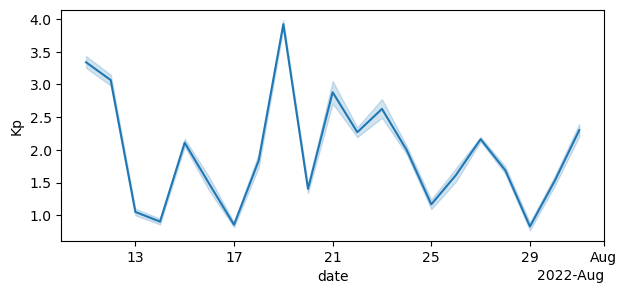

In [202]:
fig, ax = plt.subplots(figsize=(7, 3))
sns.lineplot(data=rmse_df, x='date', y='Kp', ax=ax)

Text(0, 0.5, 'RMSE [kV]')

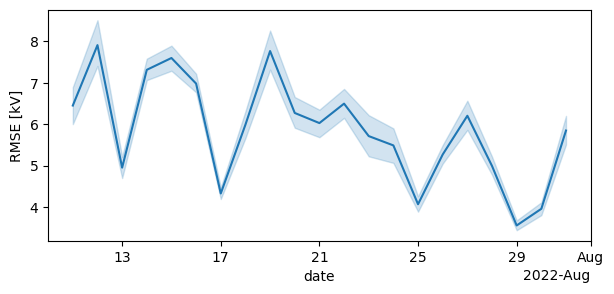

In [203]:
#plot the RMSE
fig, ax = plt.subplots(figsize=(7, 3))
sns.lineplot(data=rmse_df, x='date', y='RMSE', ax=ax)
plt.ylabel('RMSE [kV]')
#plt.xticks(np.arange(0, 25, 3))
#plt.xlabel('UTC')

In [39]:
rmse_df.groupby('date').mean().sort_values(by='RMSE', ascending=True)

,RMSE,dt,hr,SYM_H
date,,,,
2022-07-29,3.526693,2022-07-29 11:59:08.936169984,11.524823,1.078014
2022-07-30,3.949693,2022-07-30 11:58:31.267605760,11.517606,8.380282
2022-07-25,4.343642,2022-07-25 12:01:45.263157760,11.571930,-8.887719
2022-07-17,4.677750,2022-07-17 11:56:00.854092288,11.476868,-5.007117
2022-07-13,4.709381,2022-07-13 10:48:32.790697728,10.348837,-15.383721
2022-07-28,4.781795,2022-07-28 11:58:26.451612928,11.516129,-2.612903
2022-07-26,5.070294,2022-07-26 11:59:13.763440896,11.530466,-13.924731
2022-07-24,5.519275,2022-07-24 11:57:06.923076864,11.493007,-17.251748
2022-07-23,5.687600,2022-07-23 12:18:45.000000000,11.855072,-19.068841


In [13]:
#print unique dates from ds_pred dt
dates = ds_pred['dt'].dt.strftime('%Y-%m-%d').values
unique_dates = np.unique(dates)
unique_dates

array(['2022-07-11', '2022-07-12', '2022-07-13', '2022-07-14',
       '2022-07-15', '2022-07-16', '2022-07-17', '2022-07-18',
       '2022-07-19', '2022-07-20', '2022-07-21', '2022-07-22',
       '2022-07-23', '2022-07-24', '2022-07-25', '2022-07-26',
       '2022-07-27', '2022-07-28', '2022-07-29', '2022-07-30',
       '2022-07-31'], dtype=object)

In [14]:
date = '2022-07-31'

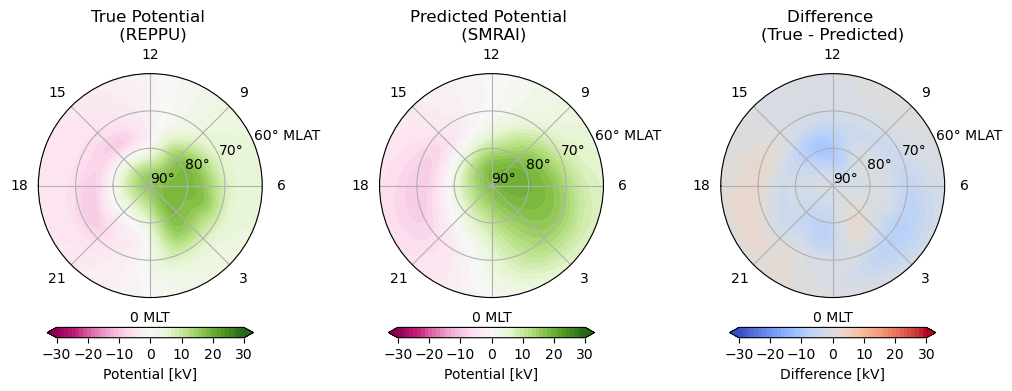

In [15]:
# Define the date
date = "2022-07-31"

# Extract true and predicted values
pot_true = ds_test['potential'].sel(dt=date).values[0]
pot_pred = ds_pred['potential'].sel(dt=date).values[0]

# Calculate the difference
diff = pot_true - pot_pred

# Set up the plot
fig, axs = plt.subplots(1, 3, subplot_kw={'projection': 'polar'}, figsize=(14, 4))

# Define common parameters
theta = np.linspace(0, 360, 80) - 90
theta_rad = theta / 360 * 2 * np.pi
r = 90 - np.linspace(53.1, 89.7, 30)
shrink = .3

# Plot true values
c_true = axs[0].contourf(theta_rad, r, -pot_true, levels=np.linspace(-30, 30, 50), cmap='PiYG', extend='both')
axs[0].set_ylim([0, 30])
axs[0].set_yticks([0, 10, 20, 30])
axs[0].set_yticklabels(["90°", "80°", "70°", "60° MLAT"])
axs[0].set_xlim([-np.pi, np.pi])
axs[0].set_xticks(np.linspace(-np.pi, np.pi, 9)[1:])
axs[0].set_xticklabels(["21", "0 MLT", "3", "6", "9", "12", "15", "18"])
axs[0].set_title(f'True Potential \n (REPPU)')
plt.colorbar(c_true, ax=axs[0], label='Potential [kV]', shrink=shrink, pad=0.1, ticks=np.arange(-30, 31, 10), orientation='horizontal')

# Plot predicted values
c_pred = axs[1].contourf(theta_rad, r, -pot_pred, levels=np.linspace(-30, 30, 50), cmap='PiYG', extend='both')
axs[1].set_ylim([0, 30])
axs[1].set_yticks([0, 10, 20, 30])
axs[1].set_yticklabels(["90°", "80°", "70°", "60° MLAT"])
axs[1].set_xlim([-np.pi, np.pi])
axs[1].set_xticks(np.linspace(-np.pi, np.pi, 9)[1:])
axs[1].set_xticklabels(["21", "0 MLT", "3", "6", "9", "12", "15", "18"])
axs[1].set_title(f'Predicted Potential \n (SMRAI)')
plt.colorbar(c_pred, ax=axs[1], label='Potential [kV]', shrink=shrink, pad=0.1, ticks=np.arange(-30, 31, 10), orientation='horizontal')

# Plot difference
c_diff = axs[2].contourf(theta_rad, r, -diff, levels=np.linspace(-30, 30, 50), cmap='coolwarm', extend='both')
axs[2].set_ylim([0, 30])
axs[2].set_yticks([0, 10, 20, 30])
axs[2].set_yticklabels(["90°", "80°", "70°", "60° MLAT"])
axs[2].set_xlim([-np.pi, np.pi])
axs[2].set_xticks(np.linspace(-np.pi, np.pi, 9)[1:])
axs[2].set_xticklabels(["21", "0 MLT", "3", "6", "9", "12", "15", "18"])
axs[2].set_title('Difference \n(True - Predicted)')
plt.colorbar(c_diff, ax=axs[2], label='Difference [kV]', shrink=shrink, pad=0.1, ticks=np.arange(-30, 31, 10), orientation='horizontal')

plt.subplots_adjust(wspace=-0.7)  # Adjust horizontal space between subplots

plt.tight_layout()
plt.show()


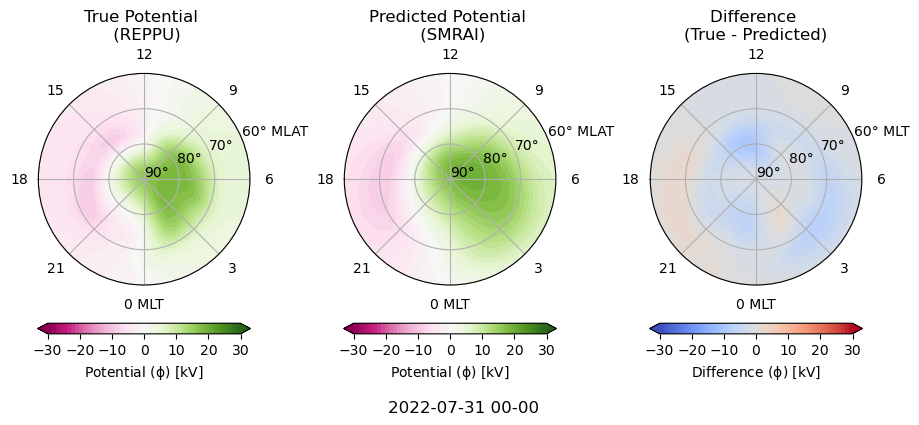

In [16]:

# Select the date
date = "2022-07-31"

# Extract times from dt dimension info
times = ds_test.sel(dt=date)['dt'].values

# Define common parameters
theta = np.linspace(0, 360, 80) - 90
theta_rad = theta / 360 * 2 * np.pi
r = 90 - np.linspace(53.1, 89.7, 30)
shrink = .28
pad = 0.13
phi = r"$\mathrm{\phi}$"

# Loop through each time step
for i, time in enumerate(times):
    # Extract true and predicted values for the current time
    pot_true = ds_test['potential'].sel(dt=date).values[i]
    pot_pred = ds_pred['potential'].sel(dt=date).values[i]

    # Calculate the difference
    diff = pot_true - pot_pred

    # Set up the plot
    fig, axs = plt.subplots(1, 3, subplot_kw={'projection': 'polar'}, figsize=(14, 4))

    # Plot true values
    c_true = axs[0].contourf(theta_rad, r, -pot_true, levels=np.linspace(-30, 30, 50), cmap='PiYG', extend='both')
    axs[0].set_ylim([0, 30])
    axs[0].set_yticks([0, 10, 20, 30])
    axs[0].set_yticklabels(["90°", "80°", "70°", "60° MLAT"])
    axs[0].set_xlim([-np.pi, np.pi])
    axs[0].set_xticks(np.linspace(-np.pi, np.pi, 9)[1:])
    axs[0].set_xticklabels(["21", "0 MLT", "3", "6", "9", "12", "15", "18"])
    axs[0].set_title(f'True Potential \n (REPPU)')
    plt.colorbar(c_true, ax=axs[0], label=f'Potential ({phi}) [kV]', shrink=shrink, pad=pad, ticks=np.arange(-30, 31, 10), orientation='horizontal')

    # Plot predicted values
    c_pred = axs[1].contourf(theta_rad, r, -pot_pred, levels=np.linspace(-30, 30, 50), cmap='PiYG', extend='both')
    axs[1].set_ylim([0, 30])
    axs[1].set_yticks([0, 10, 20, 30])
    axs[1].set_yticklabels(["90°", "80°", "70°", "60° MLAT"])
    axs[1].set_xlim([-np.pi, np.pi])
    axs[1].set_xticks(np.linspace(-np.pi, np.pi, 9)[1:])
    axs[1].set_xticklabels(["21", "0 MLT", "3", "6", "9", "12", "15", "18"])
    axs[1].set_title('Predicted Potential \n (SMRAI)')
    plt.colorbar(c_pred, ax=axs[1], label=f'Potential ({phi}) [kV]', shrink=shrink, pad=pad, ticks=np.arange(-30, 31, 10), orientation='horizontal')

    # Plot difference
    c_diff = axs[2].contourf(theta_rad, r, -diff, levels=np.linspace(-30, 30, 50), cmap='coolwarm', extend='both')
    axs[2].set_ylim([0, 30])
    axs[2].set_yticks([0, 10, 20, 30])
    axs[2].set_yticklabels(["90°", "80°", "70°", "60° MLT"])
    axs[2].set_xlim([-np.pi, np.pi])
    axs[2].set_xticks(np.linspace(-np.pi, np.pi, 9)[1:])
    axs[2].set_xticklabels(["21", "0 MLT", "3", "6", "9", "12", "15", "18"])
    axs[2].set_title(f'Difference \n(True - Predicted)')
    plt.colorbar(c_diff, ax=axs[2], label=f'Difference ({phi}) [kV]', shrink=shrink, pad=pad, ticks=np.arange(-30, 31, 10), orientation='horizontal')

    plt.subplots_adjust(wspace=-0.8)  # Adjust horizontal space between subplots

    plt.tight_layout()

    dt = pd.to_datetime(time)
    str_time = dt.strftime('%Y-%m-%d %H-%M')

    plt.annotate(f'{str_time}', xy=(-1.24, -0.6), xycoords='axes fraction', fontsize=12)

    # Save the figure with the timestamp in the title
    #export_path = r'/Users/sr2/OneDrive - University College London/PhD/Experiences/Postdocs/Research/JSPS/Analysis/Apr-24/plots/SMRAI3/potential/2022-07-31/'
    #plt.savefig(f'/Users/sr2/My Drive/Career/Employment/Current/JSPS/Research/Analysis/Apr-24/plots/SMRAI3/potential/2022-07-31/potential_plot_{str_time}.png', dpi=300, bbox_inches='tight')
    
    # Close the figure to free up memory
    #plt.close(fig)

    break